In [1]:
!pip install torch

In [2]:
!pip install torchvision

In [3]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [5]:
# 경로 지정

train_path = 'C:/Users/User/Desktop/work/project2/ML_study_material/train'
test_path = 'C:/Users/User/Desktop/work/project2/ML_study_material/test'

A_dir = '/A/'
B_dir = '/B/'
C_dir = '/C/'

In [6]:
resize_trans = transforms.Compose([
                                   transforms.Resize((224,224)),
                                   transforms.ToTensor()
])

In [7]:
resize_train = torchvision.datasets.ImageFolder(root=train_path, transform = resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path, transform = resize_trans)

In [8]:
resize_train[0][0].shape

torch.Size([3, 224, 224])

In [9]:
import numpy as np
np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB mean/std 뽑기

array([0.3622457 , 0.43432653, 0.55683714], dtype=float32)

In [10]:
def get_mean_std(dataset):
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print(meanR, meanG, meanB)
    print(stdR, stdG, stdB)

In [11]:
# normalization 준비

resize_train_mean=[0.17191947, 0.41128376, 0.56153077]
resize_train_std=[0.16150557, 0.16577946, 0.16063999]

resize_test_mean=[0.15918699, 0.410329, 0.55247366]
resize_test_std=[0.1542138, 0.16098696, 0.15552239]

In [12]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)


In [13]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_path, transform=None)

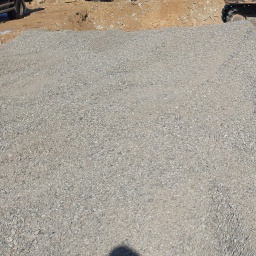

In [14]:
# 원본 이미지
none_trans[5][0]

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=0)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=0)

In [16]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [17]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [18]:
resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(device) 
# resnet50
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [19]:
!pip install torchsummary

In [20]:
# 출력 tensor가 맞는지 확인해보자

from torchsummary import summary
summary(resnet50, input_size=(3, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           1,024
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,216
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]           4,096
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

In [21]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [22]:
# 첫 번째 layer의 filter를 확인해보자 (=가중치 확인) -> 나중에 학습을 완료한 후의 filter도 확인하기
for w in resnet50.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# 가중치 renormalization
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=6, padding=1)

plt.figure(figsize=(10, 10))
#imshow(x_grid)

torch.Size([32, 3, 3, 3])


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [23]:
# config 모델 파라미터 인자를 만들기위한 클래스
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [24]:
lr = 0.0008
epochs = 30
optimizer = 'Adam'

In [25]:
# 파라미터 클래스
config = Config(
    trainloader = trainloader,
    testloader = testloader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [26]:
class train_test():
    def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(trainloader))
    def train(self, epochs, log_interval):
        self.model.train()
        for epoch in range(1, epochs + 1 ):  # epochs 루프
            running_loss = 0.0
            lr_sche.step()
            for i, data in enumerate(self.trainloader, 0): # batch 루프
                # get the inputs
                self.globaliter += 1
                inputs, labels = data # input data, label 분리
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # 가중치 초기화 -> 이전 batch에서 계산되었던 가중치를 0으로 만들고 최적화 진행
                self.optimizer.zero_grad() 

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                # 30 iteration마다 acc & loss 출력
                if i % log_interval == log_interval -1 : # i는 1에포크의 iteration
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

                    #with train_summary_writer.as_default():
                    #    summary.scalar('loss', loss.item() , step = self.globaliter)

            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0
                acc = []
                for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()
                    acc.append(100 * correct/total)

                print('\nTest set : Average loss:{:.4f}, Accuracy: {}/{}({:.0f}%)\n'.format(
                  test_loss, correct, total, 100 * correct/total
                ))
                  #with test_summary_writer.as_default():
                  #    summary.scalar('loss', test_loss , step = self.globaliter)
                  #    summary.scalar('accuracy', 100 * correct/total , step = self.globaliter)  
##                      if acc [k] > 60 and acc[k] > acc[k-1]:
#                         torch.save({
#                                     'epoch': epoch,
#                                     'model_state_dict': self.model.state_dict(),
#                                     'optimizer_state_dict': self.optimizer.state_dict(),
#                                     'loss': test_loss
#                                     }, PATH)
                         
    print('Finished Training')

Finished Training


In [27]:
ready_to_train=train_test(config)

15


In [28]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=1000, gamma=0.5) # 20 step마다 lr조정
epochs = 50
log_interval = 175

ready_to_train.train(epochs, log_interval)

C:\ANACONDA\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Test set : Average loss:4.2594, Accuracy: 112/233(48%)


Test set : Average loss:4.3954, Accuracy: 113/233(48%)


Test set : Average loss:4.2224, Accuracy: 112/233(48%)


Test set : Average loss:4.0731, Accuracy: 123/233(53%)


Test set : Average loss:4.0000, Accuracy: 130/233(56%)


Test set : Average loss:3.9726, Accuracy: 127/233(55%)


Test set : Average loss:4.0563, Accuracy: 128/233(55%)


Test set : Average loss:3.9311, Accuracy: 139/233(60%)


Test set : Average loss:3.9048, Accuracy: 130/233(56%)


Test set : Average loss:3.7691, Accuracy: 146/233(63%)


Test set : Average loss:3.9581, Accuracy: 130/233(56%)


Test set : Average loss:3.7850, Accuracy: 145/233(62%)


Test set : Average loss:3.6128, Accuracy: 152/233(65%)


Test set : Average loss:4.1406, Accuracy: 120/233(52%)


Test set : Average loss:4.0604, Accuracy: 139/233(60%)


Test set : Average loss:3.6156, Accuracy: 145/233(62%)


Test set : Average loss:3.8701, Accuracy: 152/233(65%)


Test set : Average loss:4.2207

In [29]:
# 마지막 커널은 돌리다가 너무 오래걸려서 중지함